# Forward-Backwards algorithm

In this notebook the Forward-Backward algorithm is tested over some validation signals. We use the operators already defined in the FBRN model

In [2]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

### Create the model and load the data

In [3]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [4]:
# Model
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    results_folder = '../outputs/results/',
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=False
    )

In [5]:
# Generate dataset
train_set, val_set = model.CreateDataSet()

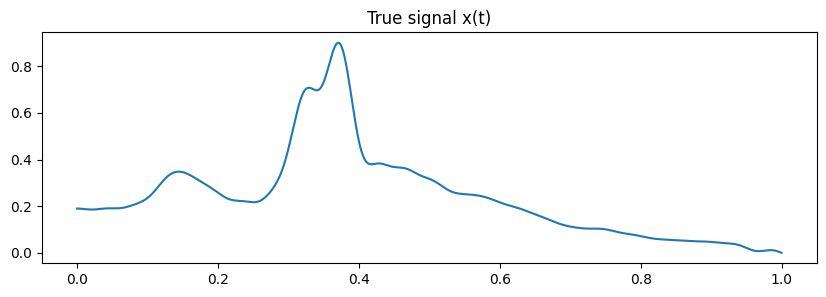

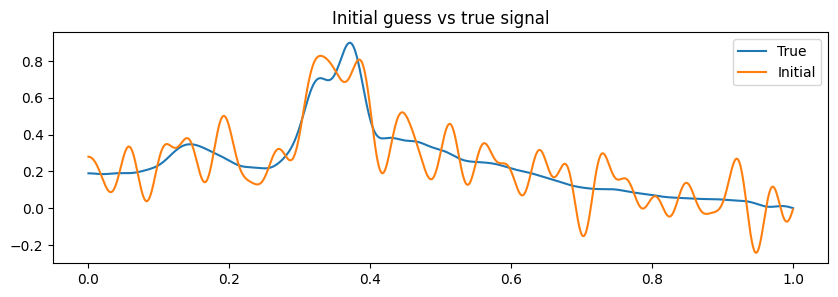

In [8]:
# Select one signal
signal_id = 1
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Prepare start value
x_init   = torch.zeros(x_bias.size())
#inv      = np.diag(model.physics.eigm**(2*model.physics.a))
inv = model.physics.inv.copy()
tTTinv   = MyMatmul(inv)
x_init   = tTTinv(y) # no filtration of high frequences
x_init   = Variable(x_init,requires_grad=False)


t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
plt.figure(figsize=(10,3))
plt.plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0])
plt.title('True signal x(t)')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0], label='True')
plt.plot(t, model.model.Layers[0].Pelt(x_init).numpy()[0,0], label='Initial')
plt.legend()
plt.title('Initial guess vs true signal')
plt.show()

### Forward Backwards Algorithm

100%|██████████| 20/20 [00:00<00:00, 357.57it/s]


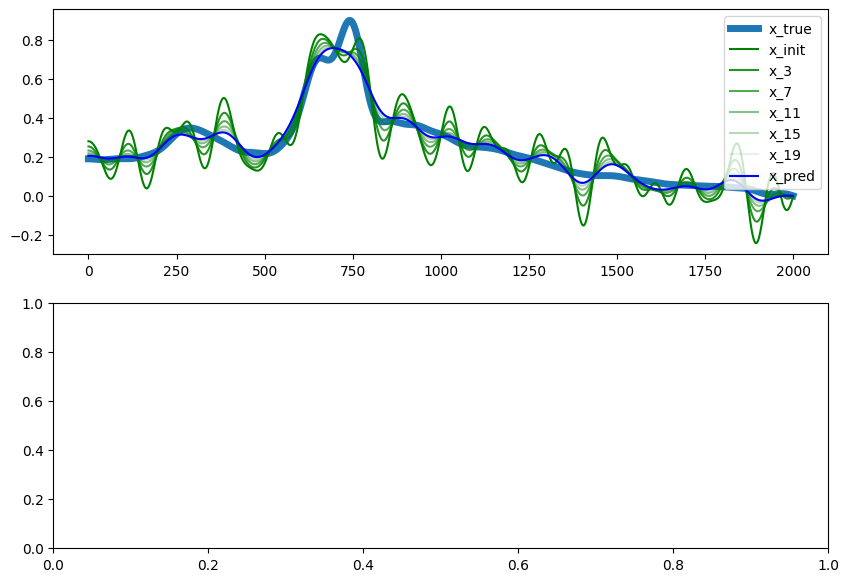

In [11]:
x_true = x.numpy()[0,0]
x_init = tTTinv(y).numpy()[0,0]

# Algorithm parameters (use values near paper results)
n_iter = 20
tau = 2e-6#2e-3 # reg in the FBRN code | 7e-2
lambda_ = 5.1#5e-4 # gamma in the FBRN code | 1.2e-4
mu = 1e-44#0.00006 # | 0.8
# Initial conditions
#b_0 = x_bias
y_obs = model.physics.Compute(model.physics.BasisChangeInv(x_true)) + np.random.randn(model.physics.nx)*0.003
b_0_np = model.physics.ComputeAdjoint(y_obs)
b_0 = model.physics.BasisChangeInv(b_0_np)
update_bias = False
#x_init_C = model.model.Layers[0].Peig(cardan.apply(lambda_*mu, model.model.Layers[0].Pelt(x_init), False, 0, 1))
x_init_C = model.physics.BasisChangeInv(x_init)
#x_init_C[0,0,10:] = 0*x_init_C[0,0,10:]
# x_init_C = torch.clone(x_true)
x_hat = x_init_C
# Operators
TT = model.physics.Tadj.dot(model.physics.Ta)
Tadj = model.physics.Tadj
model.model.eval()

im, ax = plt.subplots(2,1,figsize=(10,7))

ax[0].plot(model.physics.BasisChangeInv(x_true), label='x_true', linewidth=5)
ax[0].plot(x_hat, label='x_init', color='green')

# y_true = model.physics.Compute(model.physics.BasisChangeInv(x_true))
# y_hat = model.physics.Compute(model.physics.BasisChangeInv(x_hat))

# ax[1].plot(y_true.numpy()[0,0], label='y_true', linewidth=5)
# ax[1].plot(y_hat.numpy()[0,0], label='y_init', color='green')

for n in tqdm(range(n_iter)):
    # Compute gradient
    x_hat_eig = torch.FloatTensor(model.physics.BasisChange(x_hat))
    grad = TT.dot(x_hat) - b_0 + tau* model.physics.BasisChangeInv(model.model.Layers[0].tDD(x_hat_eig).numpy())
    x_forward = x_hat - lambda_ * grad
    # x_backwards = cardan.apply(lambda_*mu, x_forward, False,-10,10)
    x_hat = x_forward
    if (n+1)%(n_iter//5) == 0:
        # ax[0].plot(x_backwards.numpy()[0,0], color='red')
        ax[0].plot(x_hat, label='x_{}'.format(n), color='green', alpha=1-n/(n_iter+1))
        # y_hat = model.physics.Compute(model.physics.BasisChangeInv(x_hat))
        # ax[1].plot(y_hat.numpy()[0,0], label='y_{}'.format(n), color='green', alpha=1-n/(n_iter+1))

y_hat = model.physics.Compute(x_hat)

ax[0].plot(x_hat, label='x_pred', color='blue')
# ax[1].plot(y_hat.numpy()[0,0], label='x_pred', color='blue')
ax[0].legend()
# ax[1].legend()
plt.show()


In [1]:
im, ax = plt.subplots(2,1,figsize=(10,17))

ax[0].plot(x_true.numpy()[0,0], label='x_true', linewidth=3)
ax[0].plot(x_hat.numpy()[0,0], label='x_pred')
ax[0].plot(x_init_C.numpy()[0,0], label='x_init')
ax[0].legend()
ax[0].set_title('Eigenvector basis')

ax[1].plot(model.physics.BasisChangeInv(x_true).numpy()[0,0], label='x_true', linewidth=3)
ax[1].plot(model.physics.BasisChangeInv(x_hat).numpy()[0,0], label='x_pred')
ax[1].plot(model.physics.BasisChangeInv(x_init_C).numpy()[0,0], label='x_init')
ax[1].legend()
ax[1].set_title('Finite elements basis')

plt.show()


NameError: name 'plt' is not defined